In [1]:
import torch
import numpy  as np
import pandas as pd

import os, gc, time

import matplotlib.pyplot as plt

def free_memory():
    gc.collect()
    torch.cuda.empty_cache()
    gc.collect()
    
################################################################################################################################################################################################################################################################################   
def isin_via_searchsorted(elements,test_elements_sorted):  
    """
    Must be faster than isin(assume_unique=True), but needs sort instead of deduplication (it's also can be using sort)
    I've tested it and now I'm pretty sure it works correctly

    :param elements             : torch.tensor
    :param test_elements_sorted : torch.tensor - must be sorted

    :return: boolean tensor the size of elements
    """
    ts = torch.searchsorted(test_elements_sorted,elements)
    ts[ts>=len(test_elements_sorted)] = len(test_elements_sorted)-1
    return (test_elements_sorted[ts] == elements)

################################################################################################################################################################################################################################################################################   
def signed_to_hex(number, bits=64):
    mask = (1 << bits) - 1  # Маска для обрезки до нужного размера
    unsigned = number & mask
    hex_str = f"{unsigned:0{bits//4}X}"  # Форматирование в HEX с ведущими нулями
    return f"0x{hex_str}"

In [2]:
class LRX_bit:
    def __init__(self, N, X_width=2, dtype='Auto', device='Auto', arange_in_bits=None, verbose=-1):
        
        # it's better for speed to store all data in the same device
        if device == 'Auto':
            if torch.cuda.is_available():
                self.device = torch.device("cuda")
            else:
                self.device = torch.device("cpu")
        else:
            self.device = device

        self.mult             = 64
        self.mult_log         = 1

        self.dtype            = torch.int64

        self.N                = N
        self.state_size       = N//2

        self.steps             = torch.tensor(list(reversed([2**q if q<63 else -1 for q in range(self.N)])), device=self.device, dtype=self.dtype)

        self.head_nuller       = torch.tensor(0b1111111111111111111111111111111111111111111111111111111111111111 >> (self.mult_log*(self.mult-self.N)), dtype=torch.uint64).to(torch.int64)
        self.X_mask_0          = torch.tensor(0b1000000000000000000000000000000000000000000000000000000000000000 >> (self.mult_log*(self.mult-self.N)), dtype=torch.uint64).to(torch.int64)
        self.X_mask_1          = torch.tensor(0b0100000000000000000000000000000000000000000000000000000000000000 >> (self.mult_log*(self.mult-self.N)), dtype=torch.uint64).to(torch.int64)
        self.X_mask_N          = torch.tensor(0b0011111111111111111111111111111111111111111111111111111111111111 >> (self.mult_log*(self.mult-self.N)), dtype=torch.uint64).to(torch.int64)

        self.state_destination = torch.arange(self.N, dtype=self.dtype, device=self.device)//self.state_size\
                                     if arange_in_bits is None else \
                                 torch.tensor(arange_in_bits, dtype=self.dtype, device=self.device)
        
        self.state_destination = (self.state_destination*self.steps).sum().reshape((-1,))#((self.mult)*self.state_destination[::2] + self.state_destination[1::2]).reshape((1,-1))

        
    ################################################################################################################################################################################################################################################################################
    
    # bit of setup to get the fastest make_hashes - now it's possible always make_hashes_cpu_and_modern_gpu because of using float64 for self.dtype_for_hash
    
    def check_state(self, state):
        return [signed_to_hex(q.item()) for q in state]

    def make_state(self, state):
        return (state*self.steps).sum().reshape((-1,1))

    def L(self, states):
        return ((states >> (self.mult_log*(self.N-1))) + (states << self.mult_log)) & self.head_nuller

    def R(self, states):
        return ((states << (self.mult_log*(self.N-1))) + (states >> self.mult_log)) & self.head_nuller

    def X(self, states): # must be rewritten if X_width > 2
        return  ((states & self.X_mask_N) |
                ((states & self.X_mask_0) >> self.mult_log) |
                ((states & self.X_mask_1) << self.mult_log))
        
    def bfs_growth(self, max_steps=1000, print_thres = 100, verbose=0):
        tic = time.time()
        growth_dict = {0:1,}

        adresator = [dict(), dict(), dict(),]

        adresator[0]['X'] = self.state_destination.detach().clone()
        adresator[0]['L'] = self.state_destination.detach().clone()
        adresator[0]['R'] = self.state_destination.detach().clone()
        
        adresator[1]['X'] = self.X(self.state_destination)
        adresator[1]['L'] = self.L(self.state_destination)
        adresator[1]['R'] = self.R(self.state_destination)

        for p in 'XLR':
            for q in 'XLR':
                if adresator[1][p].shape[0]>0 and adresator[0][q].shape[0]>0:
                    adresator[1][p] = adresator[1][p][ ~isin_via_searchsorted(adresator[1][p], adresator[0][q]) ]

        pairs = [('X', 'L'), ('X', 'R'), ('L', 'R'),]
            
        for p,q in pairs:
            if adresator[1][p].shape[0]>0 and adresator[1][q].shape[0]>0:
                adresator[1][p] = adresator[1][p][ ~isin_via_searchsorted(adresator[1][p], adresator[1][q]) ]

        growth_dict[1] =  adresator[1]['X'].shape[0] + adresator[1]['L'].shape[0] + adresator[1]['R'].shape[0]
        
        
        for i in range(2,max_steps):
            adresator[i%3]['X'] = torch.hstack([self.X(adresator[(i-1)%3]['L']), self.X(adresator[(i-1)%3]['R']),]).sort(stable=True).values
            adresator[i%3]['L'] = torch.hstack([self.L(adresator[(i-1)%3]['L']), self.L(adresator[(i-1)%3]['X']),]).sort(stable=True).values
            adresator[i%3]['R'] = torch.hstack([self.R(adresator[(i-1)%3]['R']), self.R(adresator[(i-1)%3]['X']),]).sort(stable=True).values

            ###

            for p in 'XLR':
                for q in 'XLR':
                    if adresator[i%3][p].shape[0]>0 and adresator[(i-1)%3][q].shape[0]>0:
                        adresator[i%3][p] = adresator[i%3][p][ ~isin_via_searchsorted(adresator[i%3][p], adresator[(i-1)%3][q]) ]
    
                    if adresator[i%3][p].shape[0]>0 and adresator[(i-2)%3][q].shape[0]>0:
                        adresator[i%3][p] = adresator[i%3][p][ ~isin_via_searchsorted(adresator[i%3][p], adresator[(i-2)%3][q]) ]

            ###
            pairs = [('X', 'L'), ('X', 'R'), ('L', 'R'),]
            
            for p,q in pairs:
                if adresator[i%3][p].shape[0]>0 and adresator[i%3][q].shape[0]>0:
                    adresator[i%3][p] = adresator[i%3][p][ ~isin_via_searchsorted(adresator[i%3][p], adresator[i%3][q]) ]

            ###
            # print(adresator[i%3]['XS'])
            # print(adresator[i%3]['LS'])
            # print(adresator[i%3]['RS'])
                 
            growth_dict[i] = adresator[i%3]['X'].shape[0] + adresator[i%3]['L'].shape[0] + adresator[i%3]['R'].shape[0]

            if i>=print_thres:
                print( self.check_state( adresator[i%3]['X'] ) )
                print( self.check_state( adresator[i%3]['L'] ) )
                print( self.check_state( adresator[i%3]['R'] ) )
            
            if verbose > 0:
                print(i, '-', growth_dict[i], '-', time.time()-tic)
            
            if growth_dict[i] in {0,1,}:
                break

            for d in ['X', 'L', 'R']:
              del adresator[(i+1)%3][d]
            free_memory()

        return growth_dict

In [3]:
lrx = LRX_bit(8, arange_in_bits=[0,0,0,0,1,1,1,1])
sr = lrx.bfs_growth(print_thres=1000, verbose=0)
sr

{0: 1,
 1: 2,
 2: 3,
 3: 4,
 4: 6,
 5: 8,
 6: 7,
 7: 9,
 8: 10,
 9: 9,
 10: 8,
 11: 2,
 12: 1}

In [4]:
lrx = LRX_bit(8, arange_in_bits=[0,1,1,1,0,0,0,1])
print(bin(lrx.state_destination.item()))
sr = lrx.bfs_growth(print_thres=1000, verbose=0)
sr

0b1110001


{0: 1, 1: 3, 2: 5, 3: 8, 4: 11, 5: 13, 6: 12, 7: 12, 8: 3, 9: 2, 10: 0}

In [8]:
lrx = LRX_bit(8, arange_in_bits=[0,1,0,1,0,1,0,1])
print(bin(lrx.state_destination.item()))
sr = lrx.bfs_growth(print_thres=1000, verbose=0)
sr

0b1010101


{0: 1,
 1: 2,
 2: 3,
 3: 4,
 4: 6,
 5: 10,
 6: 10,
 7: 12,
 8: 8,
 9: 5,
 10: 2,
 11: 3,
 12: 4,
 13: 0}

In [5]:
lrx = LRX_bit(8, arange_in_bits=[0,0,0,0,0,0,0,0])
print(bin(lrx.state_destination.item()))
sr = lrx.bfs_growth(print_thres=1000, verbose=0)
sr = {k:v for k,v in sr.items() if v>0}
sr

0b0


{0: 1}

In [6]:
def int_to_SD(num):
    return [int(q) for q in f'{int(str(bin(num))[2:]):08d}']

In [7]:
results = dict()

for i in range(256):
    sd  = int_to_SD(i)
    lrx = LRX_bit(8, arange_in_bits=sd)
    sr  = lrx.bfs_growth(print_thres=1000, verbose=0)
    sr  = {k:v for k,v in sr.items() if v>0}
    results[i] = {
        'int': i      ,
        'sum': sum(sd),
        'sr' : sr     ,
    }
    print(i, end = '-')

0-1-2-3-4-5-6-7-8-9-10-11-12-13-14-15-16-17-18-19-20-21-22-23-24-25-26-27-28-29-30-31-32-33-34-35-36-37-38-39-40-41-42-43-44-45-46-47-48-49-50-51-52-53-54-55-56-57-58-59-60-61-62-63-64-65-66-67-68-69-70-71-72-73-74-75-76-77-78-79-80-81-82-83-84-85-86-87-88-89-90-91-92-93-94-95-96-97-98-99-100-101-102-103-104-105-106-107-108-109-110-111-112-113-114-115-116-117-118-119-120-121-122-123-124-125-126-127-128-129-130-131-132-133-134-135-136-137-138-139-140-141-142-143-144-145-146-147-148-149-150-151-152-153-154-155-156-157-158-159-160-161-162-163-164-165-166-167-168-169-170-171-172-173-174-175-176-177-178-179-180-181-182-183-184-185-186-187-188-189-190-191-192-193-194-195-196-197-198-199-200-201-202-203-204-205-206-207-208-209-210-211-212-213-214-215-216-217-218-219-220-221-222-223-224-225-226-227-228-229-230-231-232-233-234-235-236-237-238-239-240-241-242-243-244-245-246-247-248-249-250-251-252-253-254-255-

In [11]:
results[12]

{'int': 12,
 'sum': 2,
 'sr': {0: 1, 1: 2, 2: 2, 3: 2, 4: 3, 5: 2, 6: 4, 7: 5, 8: 4, 9: 3}}

In [14]:
for i in range(len(results)):
    for j in results[i]['sr']:
        results[i][f'sr_{j}'] = results[i]['sr'][j]

In [107]:
df = pd.DataFrame.from_dict(results).T

df['bin'] = df['int'].apply(lambda x: f'{int(str(bin(x))[2:]):08d}')

df['max'] = df['sr'].apply(lambda x: max(list(x.keys())))

df = df.fillna(0)

# df = df[df['sum']<5]

<ipython-input-107-370e51af1462>:7: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df = df.fillna(0)


In [108]:
df[df['bin'].isin({'00001111','00110011','01010101'})].T

,15,51,85
int,15,51,85
sum,4,4,4
sr,"{0: 1, 1: 2, 2: 3, 3: 4, 4: 6, 5: 8, 6: 7, 7: ...","{0: 1, 1: 2, 2: 3, 3: 4, 4: 8, 5: 16, 6: 10, 7...","{0: 1, 1: 2, 2: 3, 3: 4, 4: 6, 5: 10, 6: 10, 7..."
sr_0,1,1,1
sr_1,2,2,2
sr_2,3,3,3
sr_3,4,4,4
sr_4,6,8,6
sr_5,8,16,10
sr_6,7,10,10


In [109]:
dfdd = df.drop_duplicates(subset=['sr_0', 'sr_1', 'sr_2', 'sr_3', 'sr_4', 'sr_5', 'sr_6', 'sr_7', 'sr_8', 'sr_9', 'sr_10', 'sr_11', 'sr_12', 'max'], keep='first')

In [110]:
dfdd['max'].value_counts().sort_index()

max
0      1
4      1
5      1
6      3
7      5
8     15
9     20
10    10
11     7
12     5
Name: count, dtype: int64

In [111]:
dfdd.head(34)

,int,sum,sr,sr_0,sr_1,sr_2,sr_3,sr_4,sr_5,sr_6,sr_7,sr_8,sr_9,sr_10,sr_11,sr_12,bin,max
0,0,0,{0: 1},1,0,0,0,0,0,0,0,0,0,0,0,0,00000000,0
1,1,1,"{0: 1, 1: 2, 2: 2, 3: 2, 4: 1}",1,2,2,2,1,0,0,0,0,0,0,0,0,00000001,4
3,3,2,"{0: 1, 1: 2, 2: 3, 3: 4, 4: 4, 5: 5, 6: 4, 7: ...",1,2,3,4,4,5,4,4,1,0,0,0,0,00000011,8
5,5,2,"{0: 1, 1: 2, 2: 3, 3: 5, 4: 7, 5: 6, 6: 4}",1,2,3,5,7,6,4,0,0,0,0,0,0,00000101,6
6,6,2,"{0: 1, 1: 2, 2: 2, 3: 3, 4: 3, 5: 3, 6: 5, 7: ...",1,2,2,3,3,3,5,4,4,1,0,0,0,00000110,9
7,7,3,"{0: 1, 1: 2, 2: 3, 3: 4, 4: 5, 5: 6, 6: 7, 7: ...",1,2,3,4,5,6,7,9,8,6,4,1,0,00000111,11
9,9,2,"{0: 1, 1: 2, 2: 3, 3: 5, 4: 4, 5: 4, 6: 5, 7: ...",1,2,3,5,4,4,5,2,2,0,0,0,0,00001001,8
10,10,2,"{0: 1, 1: 2, 2: 2, 3: 3, 4: 5, 5: 6, 6: 6, 7: 3}",1,2,2,3,5,6,6,3,0,0,0,0,0,00001010,7
11,11,3,"{0: 1, 1: 2, 2: 3, 3: 4, 4: 7, 5: 11, 6: 13, 7...",1,2,3,4,7,11,13,11,4,0,0,0,0,00001011,8
12,12,2,"{0: 1, 1: 2, 2: 2, 3: 2, 4: 3, 5: 2, 6: 4, 7: ...",1,2,2,2,3,2,4,5,4,3,0,0,0,00001100,9


In [71]:
dfm = df.merge(df, on=['sr_0', 'sr_1', 'sr_2', 'sr_3', 'sr_4', 'sr_5', 'sr_6', 'sr_7', 'sr_8', 'sr_9', 'sr_10', 'sr_11', 'sr_12', 'max'])

#dfm = dfm[dfm['int_x']<dfm['int_y']]

In [114]:
dfm['int_x'].value_counts().head(40).tail(20)

int_x
114    2
113    2
101    2
105    2
19     2
53     2
46     2
32     2
54     2
60     2
57     2
58     2
6      1
7      1
193    1
209    1
194    1
9      1
10     1
11     1
Name: count, dtype: int64

In [106]:
68 = 1 * 8 + 14 * 4 

6

In [127]:
(dfm['int_x']+dfm['int_y']).value_counts()

255    35
63      6
222     5
237     5
243     4
       ..
258     1
288     1
305     1
315     1
3       1
Name: count, Length: 82, dtype: int64

In [130]:
(dfm['int_y']-dfm['int_x']).value_counts()

6      7
15     6
21     5
4      4
45     4
      ..
112    1
48     1
16     1
225    1
197    1
Name: count, Length: 89, dtype: int64

In [126]:
dfm[dfm['int_x']==11].T

,46
int_x,11
sum_x,3
sr_x,"{0: 1, 1: 2, 2: 3, 3: 4, 4: 7, 5: 11, 6: 13, 7..."
sr_0,1
sr_1,2
sr_2,3
sr_3,4
sr_4,7
sr_5,11
sr_6,13


In [64]:
dfm['int_y'].value_counts()

int_y
128    7
64     6
32     5
16     4
8      3
50     3
44     2
4      2
48     1
40     1
56     1
24     1
36     1
20     1
52     1
2      1
19     1
28     1
34     1
42     1
26     1
38     1
49     1
41     1
160    1
144    1
176    1
136    1
168    1
152    1
132    1
164    1
148    1
140    1
130    1
162    1
146    1
138    1
134    1
129    1
161    1
145    1
137    1
133    1
131    1
224    1
208    1
200    1
Name: count, dtype: int64

In [40]:
df.columns

Index(['int', 'sum', 'sr', 'sr_0', 'sr_1', 'sr_2', 'sr_3', 'sr_4', 'sr_5',
       'sr_6', 'sr_7', 'sr_8', 'sr_9', 'sr_10', 'sr_11', 'sr_12', 'bin',
       'max'],
      dtype='object')

{0: 1, 1: 2, 2: 3}


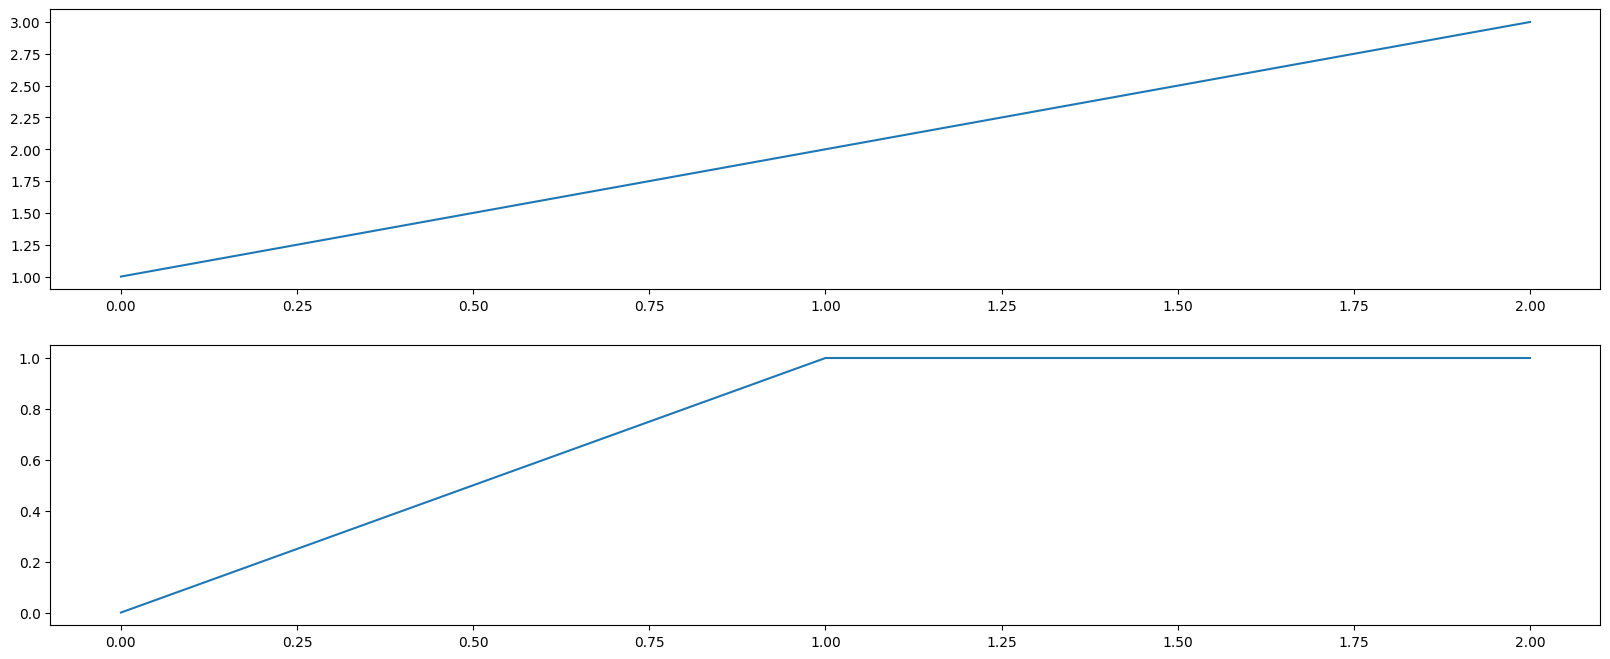

In [16]:
lrx = LRX_bit(4) # up to 63 # 64 - experimental

# states = lrx.state_destination

# signed_to_hex(states.item()),\
# signed_to_hex(lrx.R(states).item()),\
# signed_to_hex(lrx.L(states).item()),\
# signed_to_hex(lrx.X(states).item())

sr = lrx.bfs_growth(print_thres=1000, verbose=0) # 24

sr = {k:v for k,v in sr.items() if v>0}

df = pd.Series(sr).to_frame()
df[1] = df[0].diff().fillna(0)

fig, axes = plt.subplots(nrows=2, ncols=1)

df[0].plot(ax=axes[0], figsize=(20,8))
df[1].plot(ax=axes[1], figsize=(20,8))

print(str(sr))

{0: 1, 1: 2, 2: 3, 3: 4, 4: 4, 5: 3, 6: 2, 7: 1}


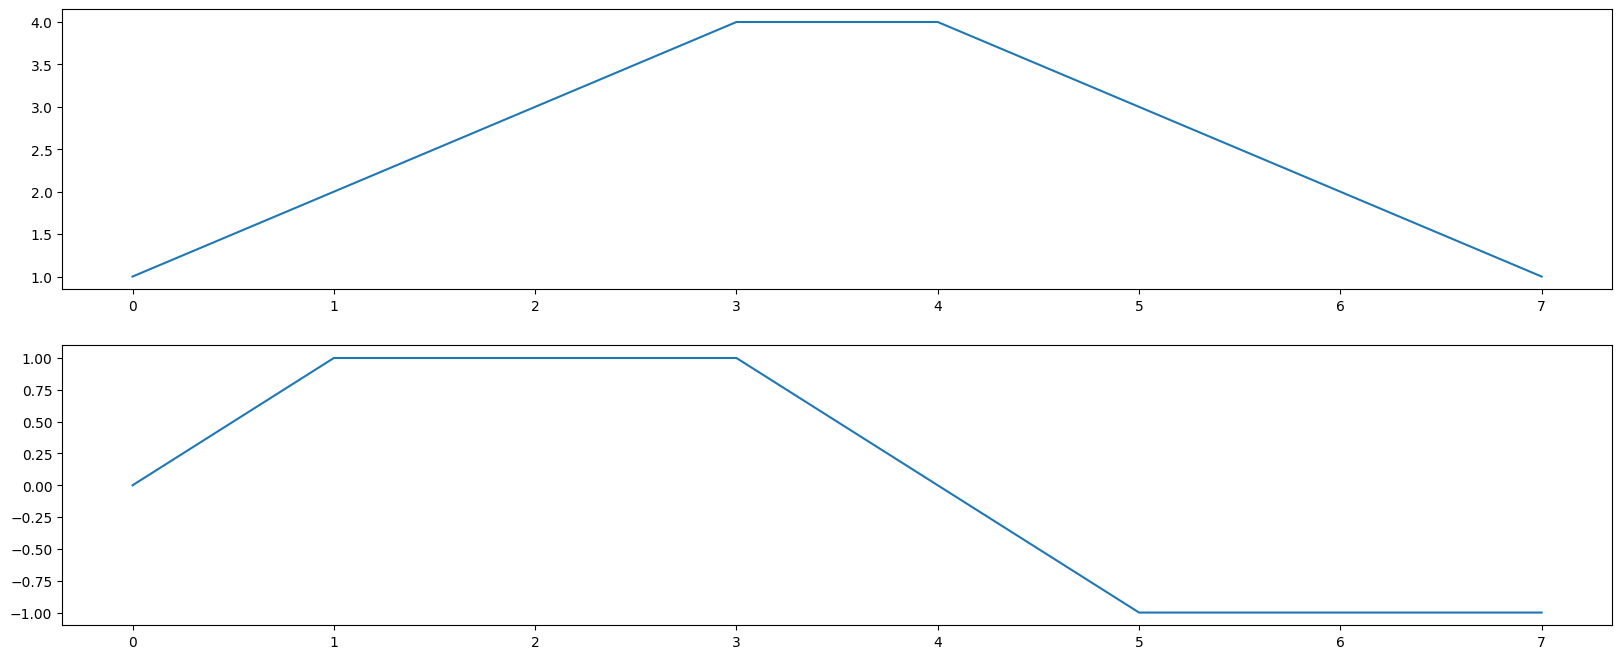

In [17]:
lrx = LRX_bit(6) # up to 63 # 64 - experimental

# states = lrx.state_destination

# signed_to_hex(states.item()),\
# signed_to_hex(lrx.R(states).item()),\
# signed_to_hex(lrx.L(states).item()),\
# signed_to_hex(lrx.X(states).item())

sr = lrx.bfs_growth(print_thres=1000, verbose=0) # 24

sr = {k:v for k,v in sr.items() if v>0}

df = pd.Series(sr).to_frame()
df[1] = df[0].diff().fillna(0)

fig, axes = plt.subplots(nrows=2, ncols=1)

df[0].plot(ax=axes[0], figsize=(20,8))
df[1].plot(ax=axes[1], figsize=(20,8))

print(str(sr))

{0: 1, 1: 2, 2: 3, 3: 4, 4: 6, 5: 8, 6: 7, 7: 9, 8: 10, 9: 9, 10: 8, 11: 2, 12: 1}


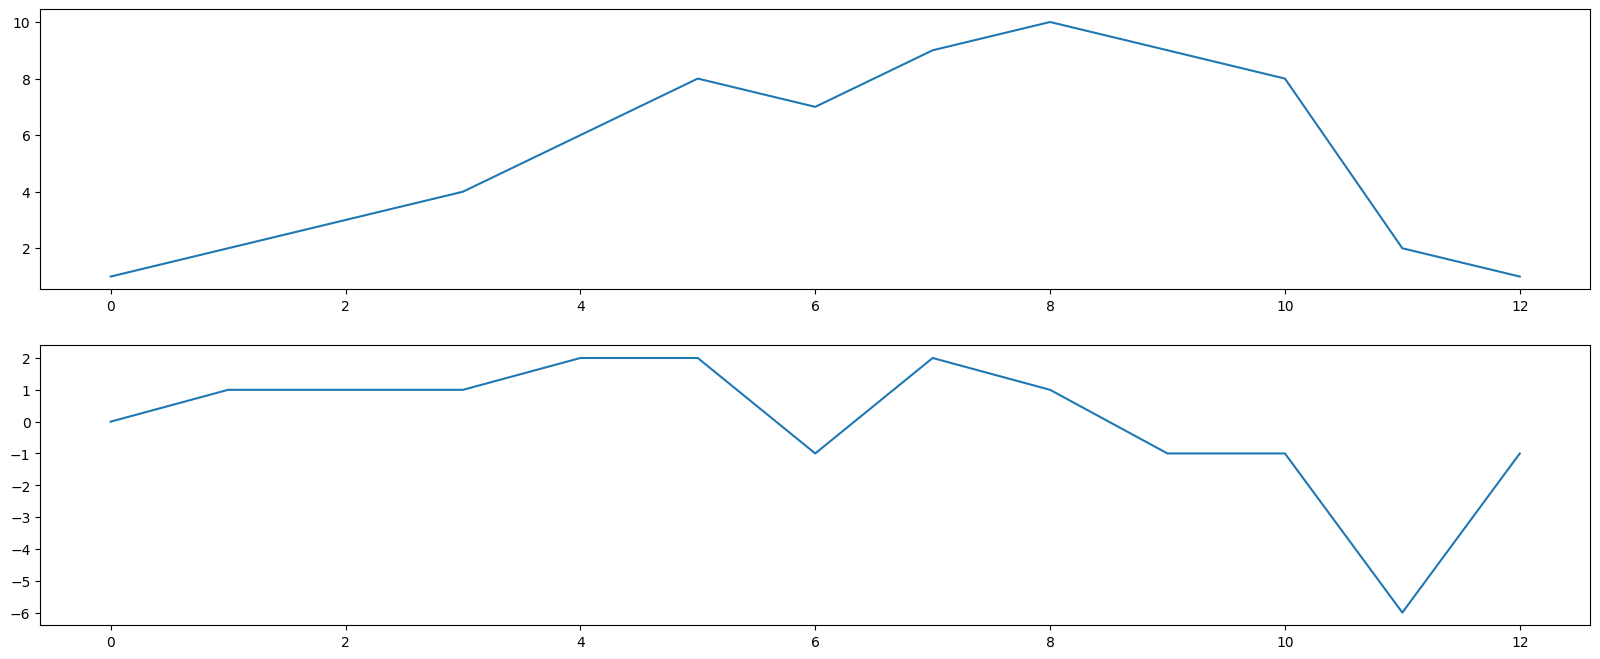

In [18]:
lrx = LRX_bit(8) # up to 63 # 64 - experimental

# states = lrx.state_destination

# signed_to_hex(states.item()),\
# signed_to_hex(lrx.R(states).item()),\
# signed_to_hex(lrx.L(states).item()),\
# signed_to_hex(lrx.X(states).item())

sr = lrx.bfs_growth(print_thres=1000, verbose=0) # 24

sr = {k:v for k,v in sr.items() if v>0}

df = pd.Series(sr).to_frame()
df[1] = df[0].diff().fillna(0)

fig, axes = plt.subplots(nrows=2, ncols=1)

df[0].plot(ax=axes[0], figsize=(20,8))
df[1].plot(ax=axes[1], figsize=(20,8))

print(str(sr))

{0: 1, 1: 2, 2: 3, 3: 4, 4: 6, 5: 8, 6: 7, 7: 9, 8: 10, 9: 9, 10: 8, 11: 2, 12: 1}


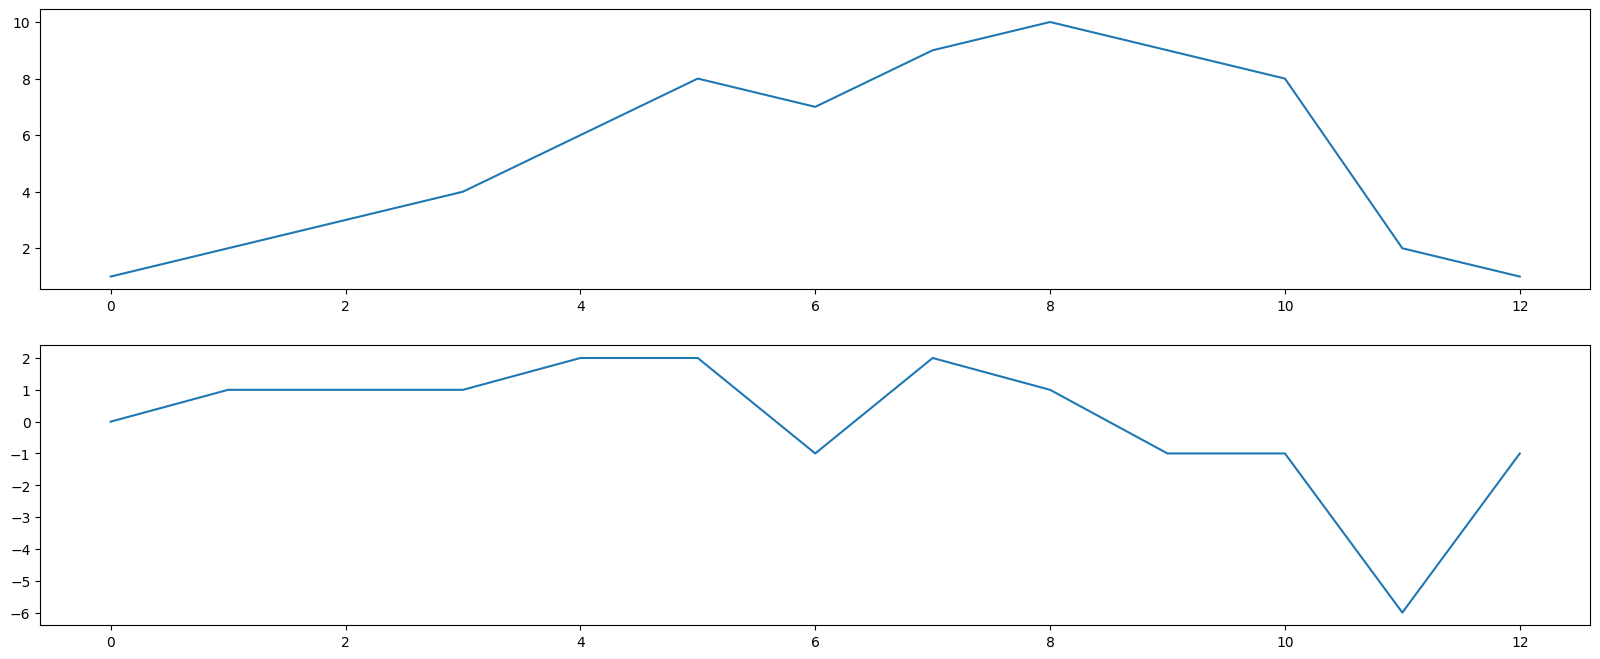

In [18]:
lrx = LRX_bit(10) # up to 63 # 64 - experimental

# states = lrx.state_destination

# signed_to_hex(states.item()),\
# signed_to_hex(lrx.R(states).item()),\
# signed_to_hex(lrx.L(states).item()),\
# signed_to_hex(lrx.X(states).item())

sr = lrx.bfs_growth(print_thres=1000, verbose=0) # 24

sr = {k:v for k,v in sr.items() if v>0}

df = pd.Series(sr).to_frame()
df[1] = df[0].diff().fillna(0)

fig, axes = plt.subplots(nrows=2, ncols=1)

df[0].plot(ax=axes[0], figsize=(20,8))
df[1].plot(ax=axes[1], figsize=(20,8))

print(str(sr))

{0: 1, 1: 2, 2: 3, 3: 4, 4: 6, 5: 8, 6: 7, 7: 9, 8: 10, 9: 9, 10: 8, 11: 2, 12: 1}


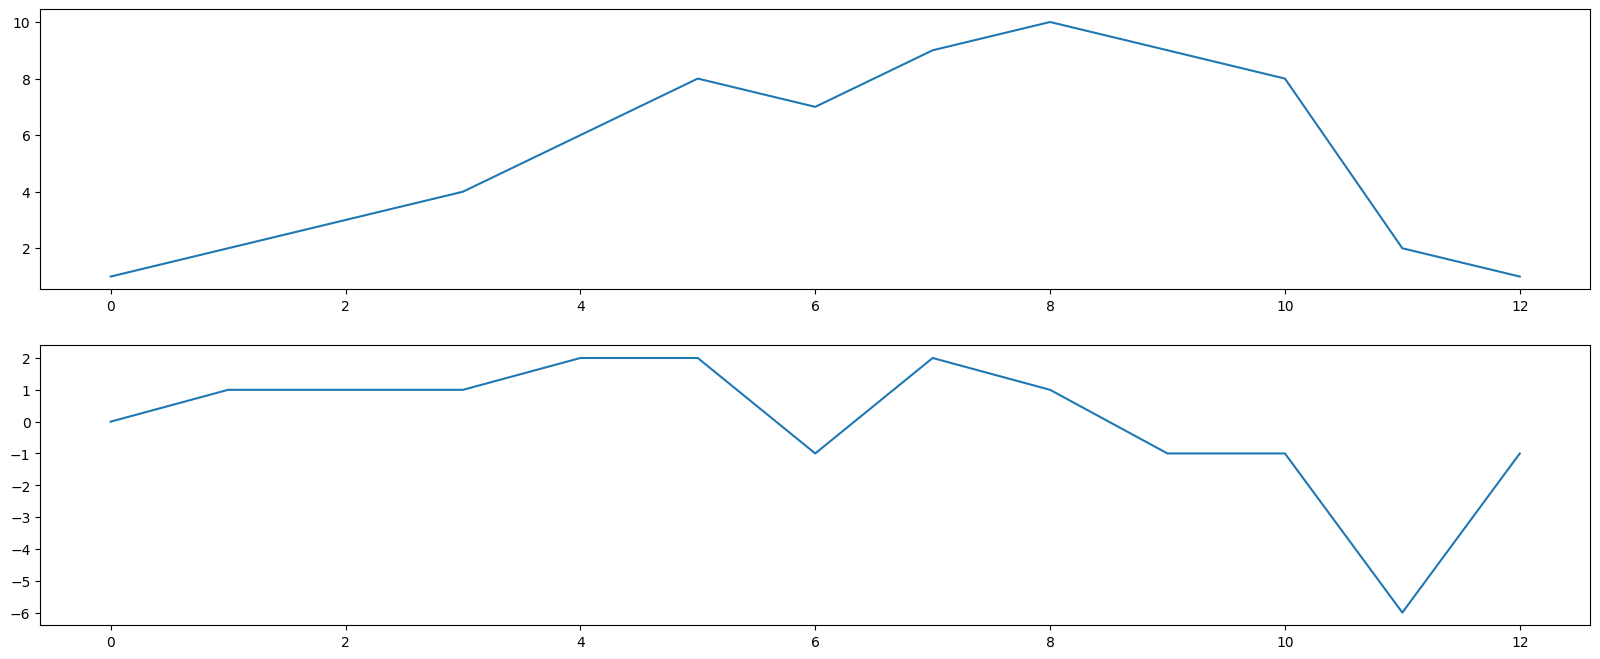

In [18]:
lrx = LRX_bit(12) # up to 63 # 64 - experimental

# states = lrx.state_destination

# signed_to_hex(states.item()),\
# signed_to_hex(lrx.R(states).item()),\
# signed_to_hex(lrx.L(states).item()),\
# signed_to_hex(lrx.X(states).item())

sr = lrx.bfs_growth(print_thres=1000, verbose=0) # 24

sr = {k:v for k,v in sr.items() if v>0}

df = pd.Series(sr).to_frame()
df[1] = df[0].diff().fillna(0)

fig, axes = plt.subplots(nrows=2, ncols=1)

df[0].plot(ax=axes[0], figsize=(20,8))
df[1].plot(ax=axes[1], figsize=(20,8))

print(str(sr))

{0: 1, 1: 2, 2: 3, 3: 4, 4: 6, 5: 8, 6: 7, 7: 9, 8: 10, 9: 9, 10: 8, 11: 2, 12: 1}


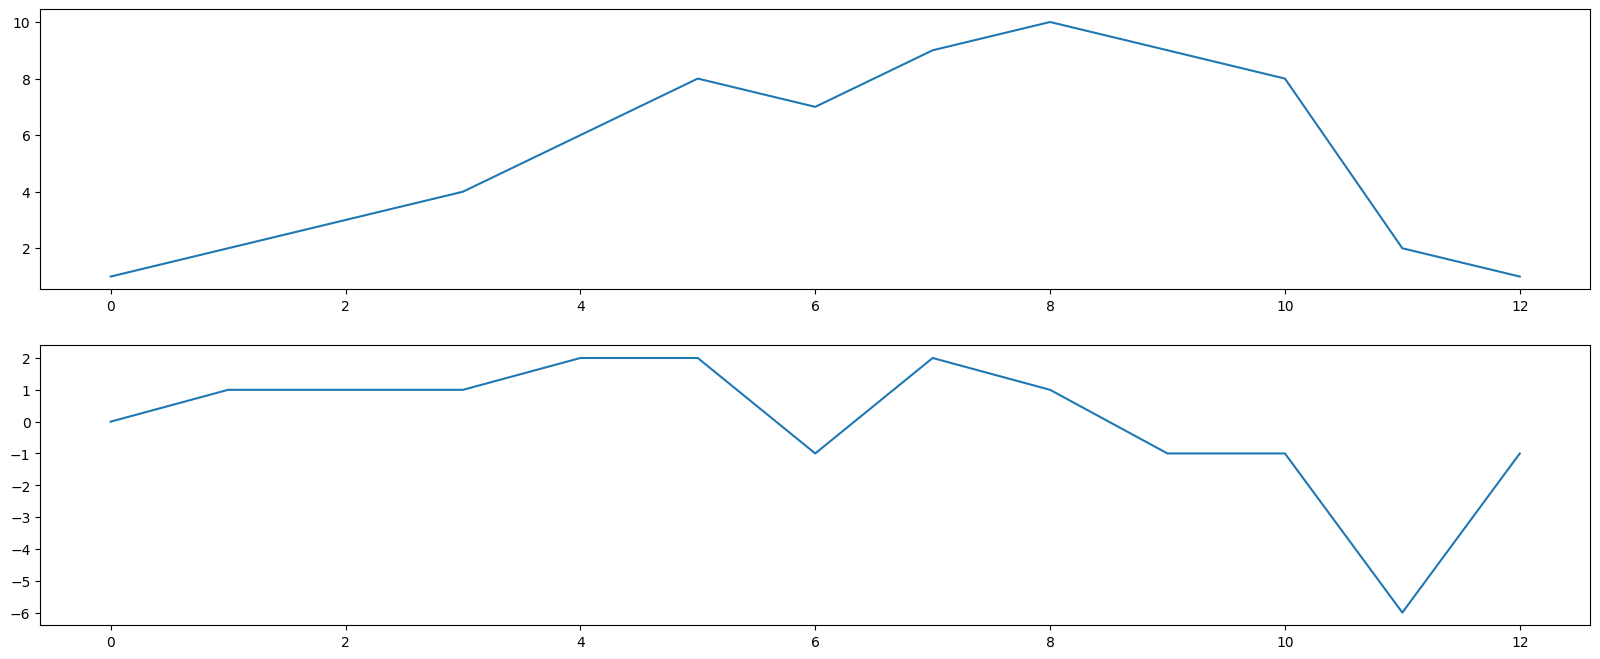

In [18]:
lrx = LRX_bit(14) # up to 63 # 64 - experimental

# states = lrx.state_destination

# signed_to_hex(states.item()),\
# signed_to_hex(lrx.R(states).item()),\
# signed_to_hex(lrx.L(states).item()),\
# signed_to_hex(lrx.X(states).item())

sr = lrx.bfs_growth(print_thres=1000, verbose=0) # 24

sr = {k:v for k,v in sr.items() if v>0}

df = pd.Series(sr).to_frame()
df[1] = df[0].diff().fillna(0)

fig, axes = plt.subplots(nrows=2, ncols=1)

df[0].plot(ax=axes[0], figsize=(20,8))
df[1].plot(ax=axes[1], figsize=(20,8))

print(str(sr))

{0: 1, 1: 2, 2: 3, 3: 4, 4: 6, 5: 8, 6: 7, 7: 9, 8: 10, 9: 9, 10: 8, 11: 2, 12: 1}


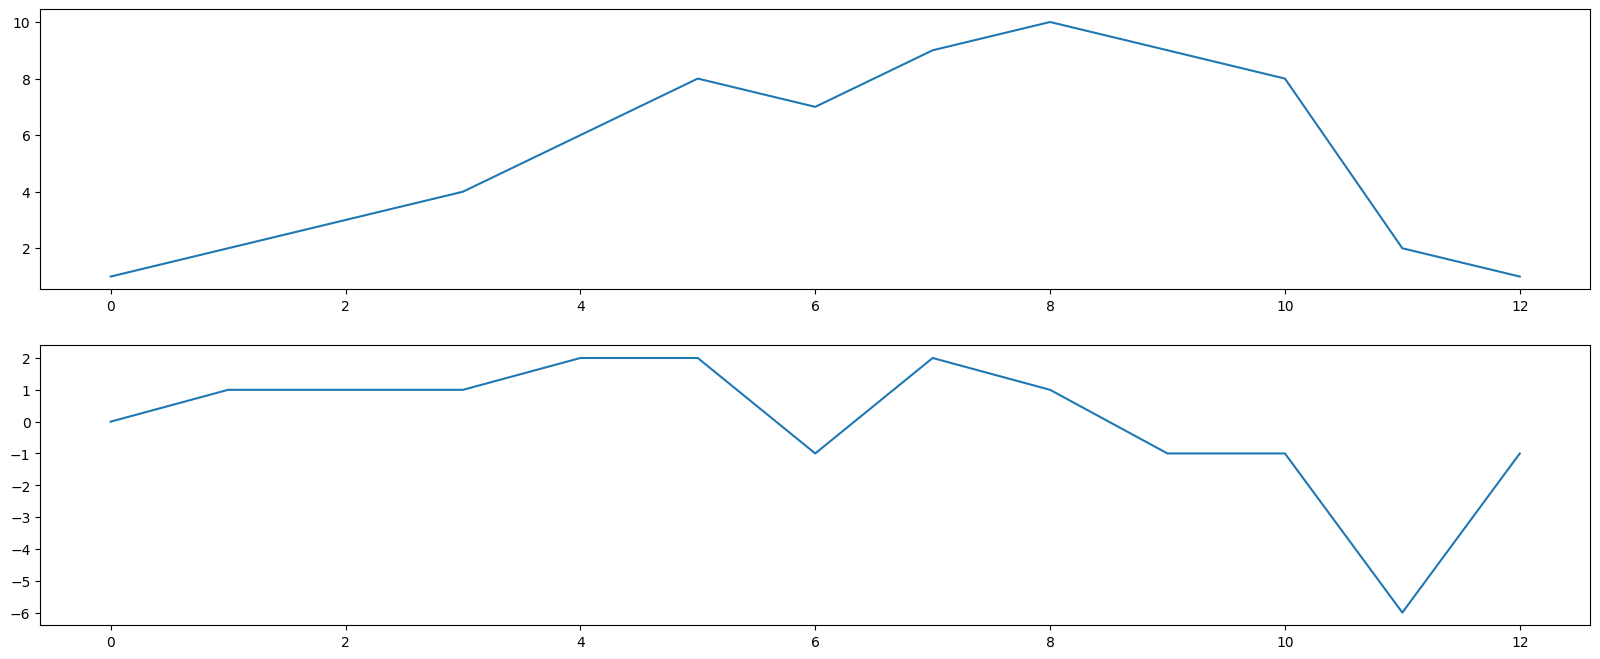

In [18]:
lrx = LRX_bit(16) # up to 63 # 64 - experimental

# states = lrx.state_destination

# signed_to_hex(states.item()),\
# signed_to_hex(lrx.R(states).item()),\
# signed_to_hex(lrx.L(states).item()),\
# signed_to_hex(lrx.X(states).item())

sr = lrx.bfs_growth(print_thres=1000, verbose=0) # 24

sr = {k:v for k,v in sr.items() if v>0}

df = pd.Series(sr).to_frame()
df[1] = df[0].diff().fillna(0)

fig, axes = plt.subplots(nrows=2, ncols=1)

df[0].plot(ax=axes[0], figsize=(20,8))
df[1].plot(ax=axes[1], figsize=(20,8))

print(str(sr))

{0: 1, 1: 2, 2: 3, 3: 4, 4: 6, 5: 8, 6: 7, 7: 9, 8: 10, 9: 9, 10: 8, 11: 2, 12: 1}


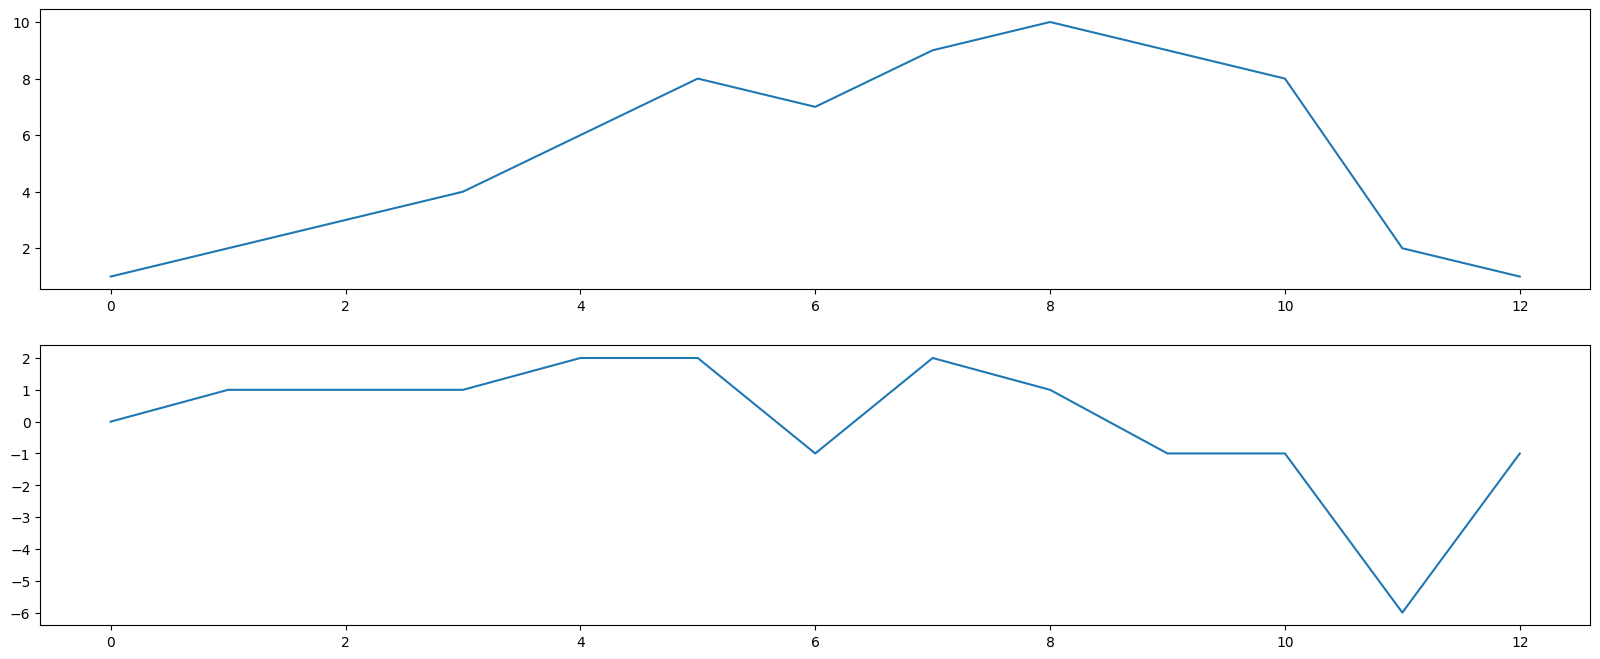

In [18]:
lrx = LRX_bit(18) # up to 63 # 64 - experimental

# states = lrx.state_destination

# signed_to_hex(states.item()),\
# signed_to_hex(lrx.R(states).item()),\
# signed_to_hex(lrx.L(states).item()),\
# signed_to_hex(lrx.X(states).item())

sr = lrx.bfs_growth(print_thres=1000, verbose=0) # 24

sr = {k:v for k,v in sr.items() if v>0}

df = pd.Series(sr).to_frame()
df[1] = df[0].diff().fillna(0)

fig, axes = plt.subplots(nrows=2, ncols=1)

df[0].plot(ax=axes[0], figsize=(20,8))
df[1].plot(ax=axes[1], figsize=(20,8))

print(str(sr))

{0: 1, 1: 2, 2: 3, 3: 4, 4: 6, 5: 8, 6: 7, 7: 9, 8: 10, 9: 9, 10: 8, 11: 2, 12: 1}


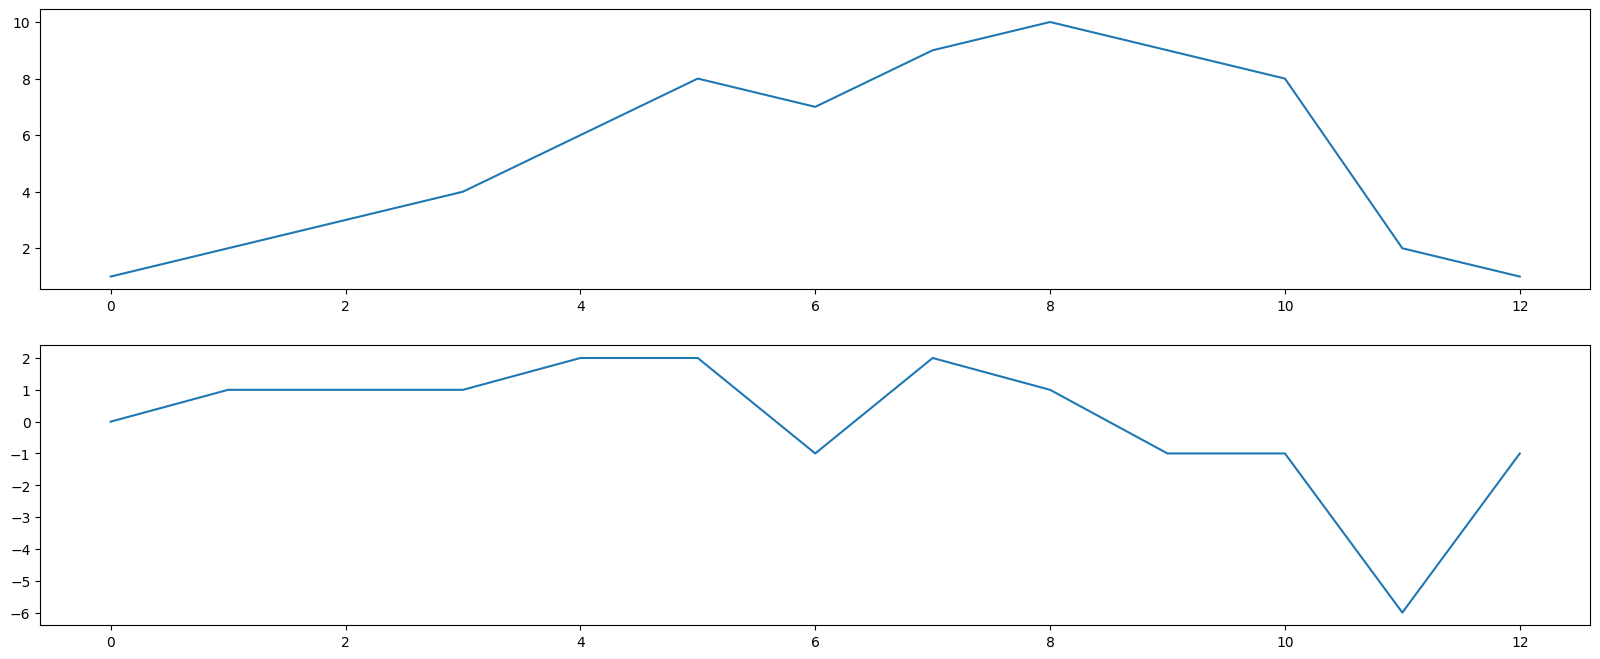

In [18]:
lrx = LRX_bit(20) # up to 63 # 64 - experimental

# states = lrx.state_destination

# signed_to_hex(states.item()),\
# signed_to_hex(lrx.R(states).item()),\
# signed_to_hex(lrx.L(states).item()),\
# signed_to_hex(lrx.X(states).item())

sr = lrx.bfs_growth(print_thres=1000, verbose=0) # 24

sr = {k:v for k,v in sr.items() if v>0}

df = pd.Series(sr).to_frame()
df[1] = df[0].diff().fillna(0)

fig, axes = plt.subplots(nrows=2, ncols=1)

df[0].plot(ax=axes[0], figsize=(20,8))
df[1].plot(ax=axes[1], figsize=(20,8))

print(str(sr))

{0: 1, 1: 2, 2: 3, 3: 4, 4: 6, 5: 8, 6: 7, 7: 9, 8: 10, 9: 9, 10: 8, 11: 2, 12: 1}


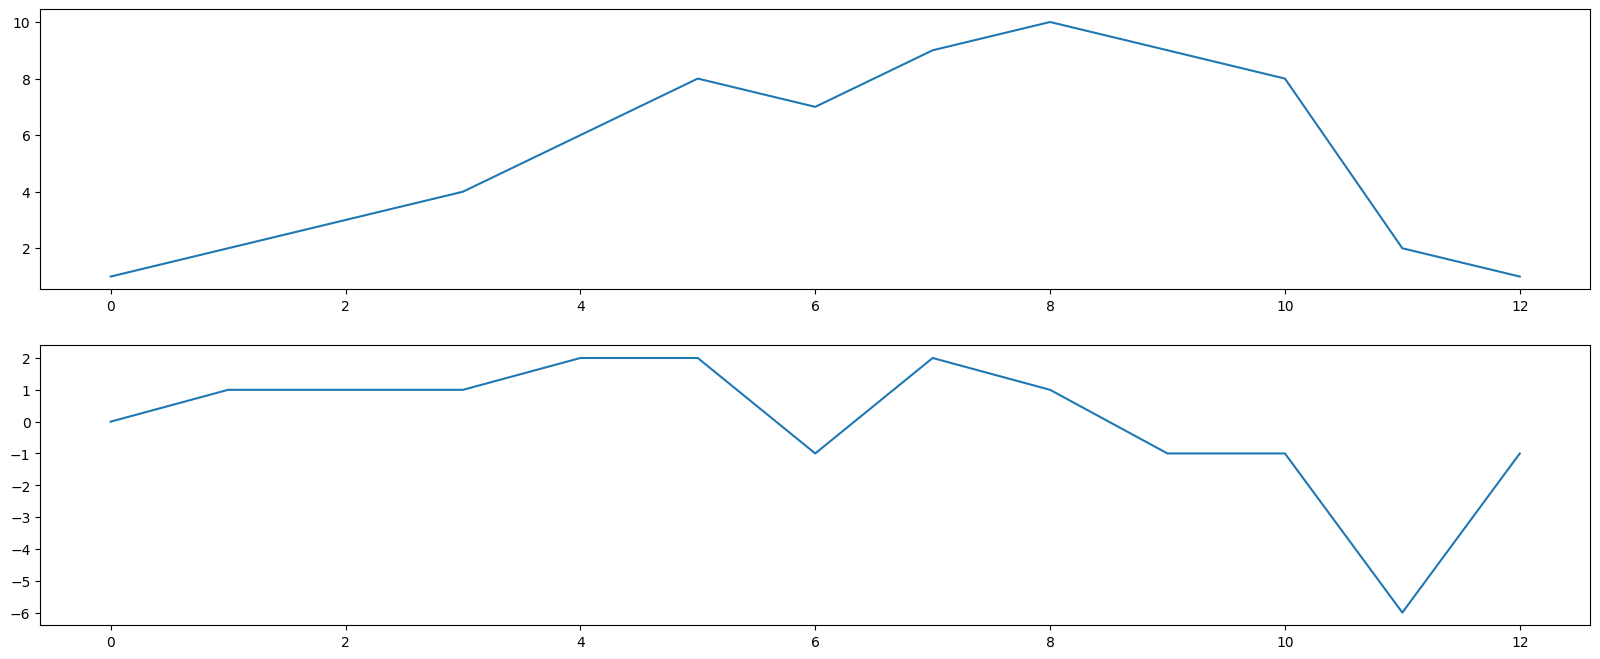

In [18]:
lrx = LRX_bit(22) # up to 63 # 64 - experimental

# states = lrx.state_destination

# signed_to_hex(states.item()),\
# signed_to_hex(lrx.R(states).item()),\
# signed_to_hex(lrx.L(states).item()),\
# signed_to_hex(lrx.X(states).item())

sr = lrx.bfs_growth(print_thres=1000, verbose=0) # 24

sr = {k:v for k,v in sr.items() if v>0}

df = pd.Series(sr).to_frame()
df[1] = df[0].diff().fillna(0)

fig, axes = plt.subplots(nrows=2, ncols=1)

df[0].plot(ax=axes[0], figsize=(20,8))
df[1].plot(ax=axes[1], figsize=(20,8))

print(str(sr))

{0: 1, 1: 2, 2: 3, 3: 4, 4: 6, 5: 8, 6: 7, 7: 9, 8: 10, 9: 9, 10: 8, 11: 2, 12: 1}


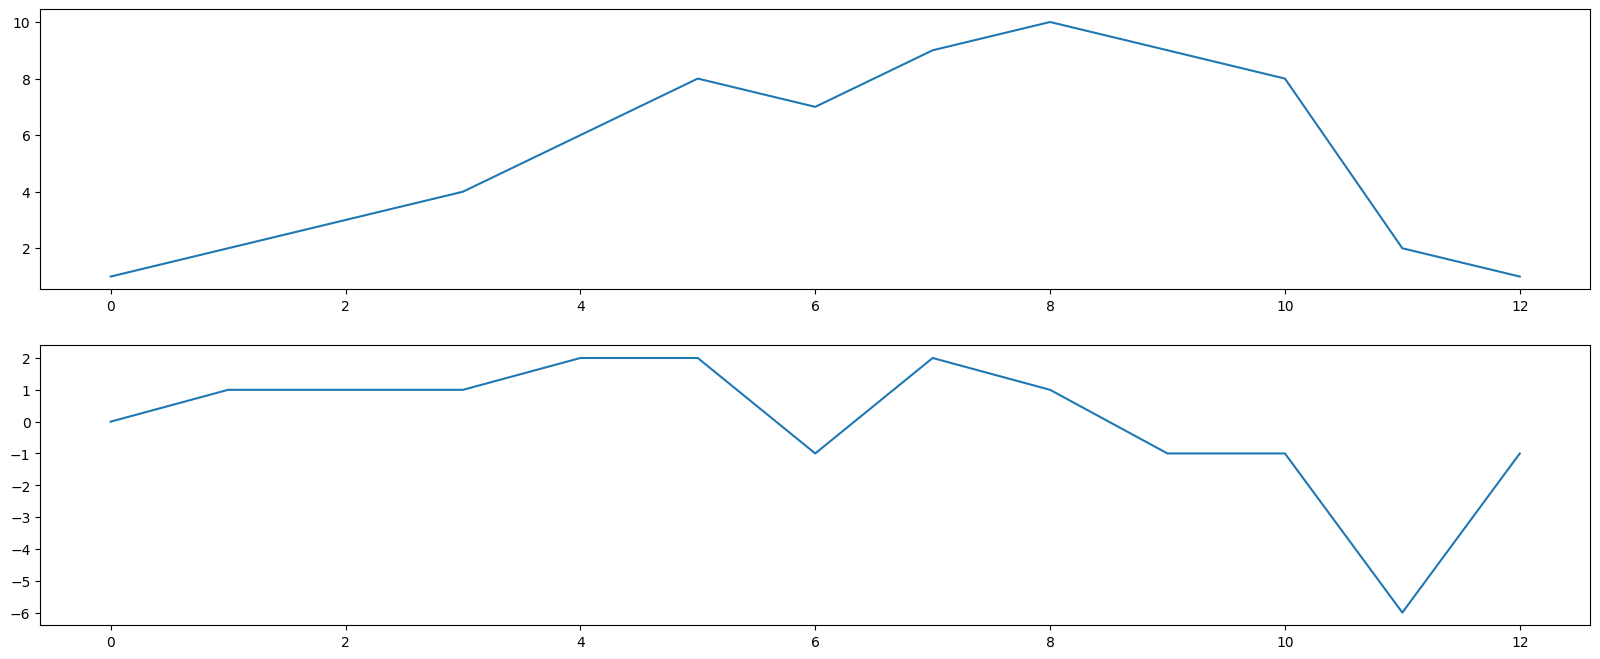

In [18]:
lrx = LRX_bit(24) # up to 63 # 64 - experimental

# states = lrx.state_destination

# signed_to_hex(states.item()),\
# signed_to_hex(lrx.R(states).item()),\
# signed_to_hex(lrx.L(states).item()),\
# signed_to_hex(lrx.X(states).item())

sr = lrx.bfs_growth(print_thres=1000, verbose=0) # 24

sr = {k:v for k,v in sr.items() if v>0}

df = pd.Series(sr).to_frame()
df[1] = df[0].diff().fillna(0)

fig, axes = plt.subplots(nrows=2, ncols=1)

df[0].plot(ax=axes[0], figsize=(20,8))
df[1].plot(ax=axes[1], figsize=(20,8))

print(str(sr))

{0: 1, 1: 2, 2: 3, 3: 4, 4: 6, 5: 8, 6: 7, 7: 9, 8: 10, 9: 9, 10: 8, 11: 2, 12: 1}


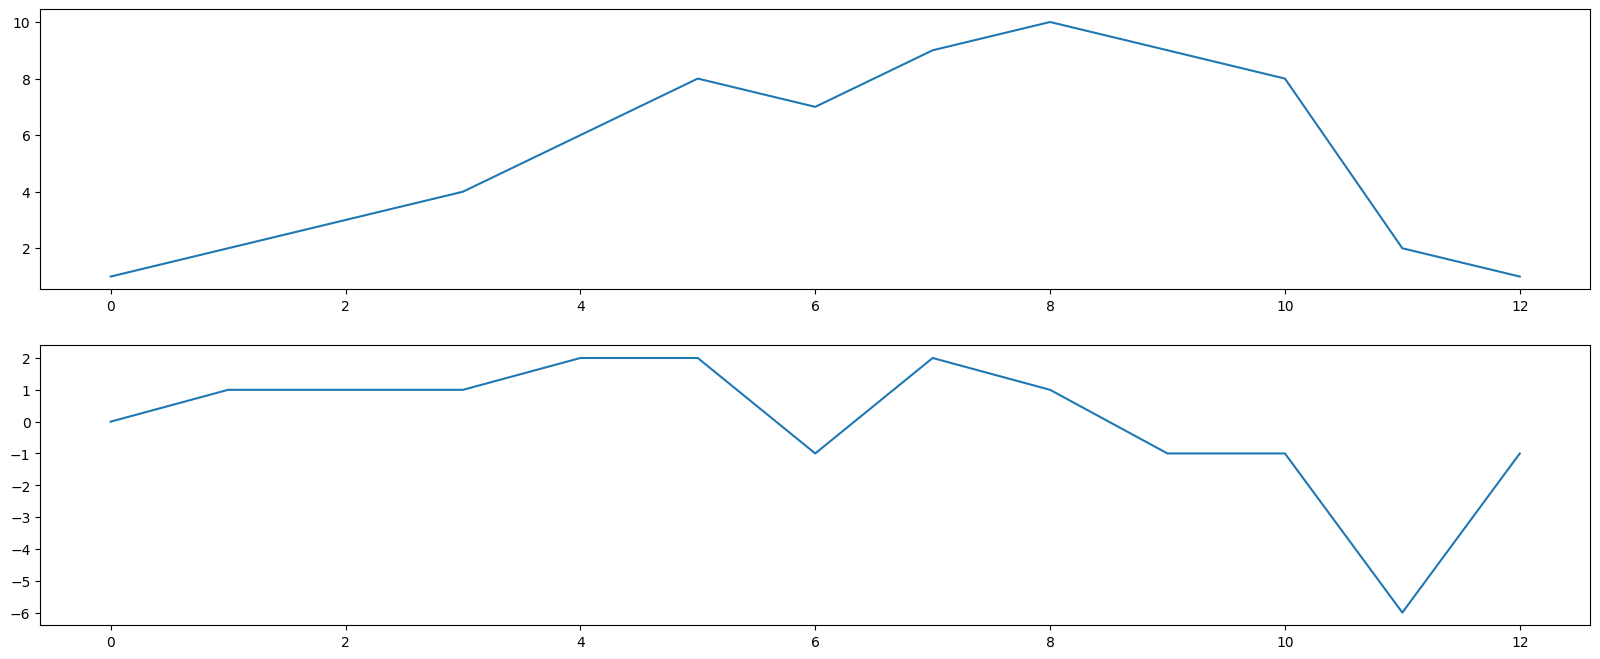

In [18]:
lrx = LRX_bit(26) # up to 63 # 64 - experimental

# states = lrx.state_destination

# signed_to_hex(states.item()),\
# signed_to_hex(lrx.R(states).item()),\
# signed_to_hex(lrx.L(states).item()),\
# signed_to_hex(lrx.X(states).item())

sr = lrx.bfs_growth(print_thres=1000, verbose=0) # 24

sr = {k:v for k,v in sr.items() if v>0}

df = pd.Series(sr).to_frame()
df[1] = df[0].diff().fillna(0)

fig, axes = plt.subplots(nrows=2, ncols=1)

df[0].plot(ax=axes[0], figsize=(20,8))
df[1].plot(ax=axes[1], figsize=(20,8))

print(str(sr))

{0: 1, 1: 2, 2: 3, 3: 4, 4: 6, 5: 8, 6: 7, 7: 9, 8: 10, 9: 9, 10: 8, 11: 2, 12: 1}


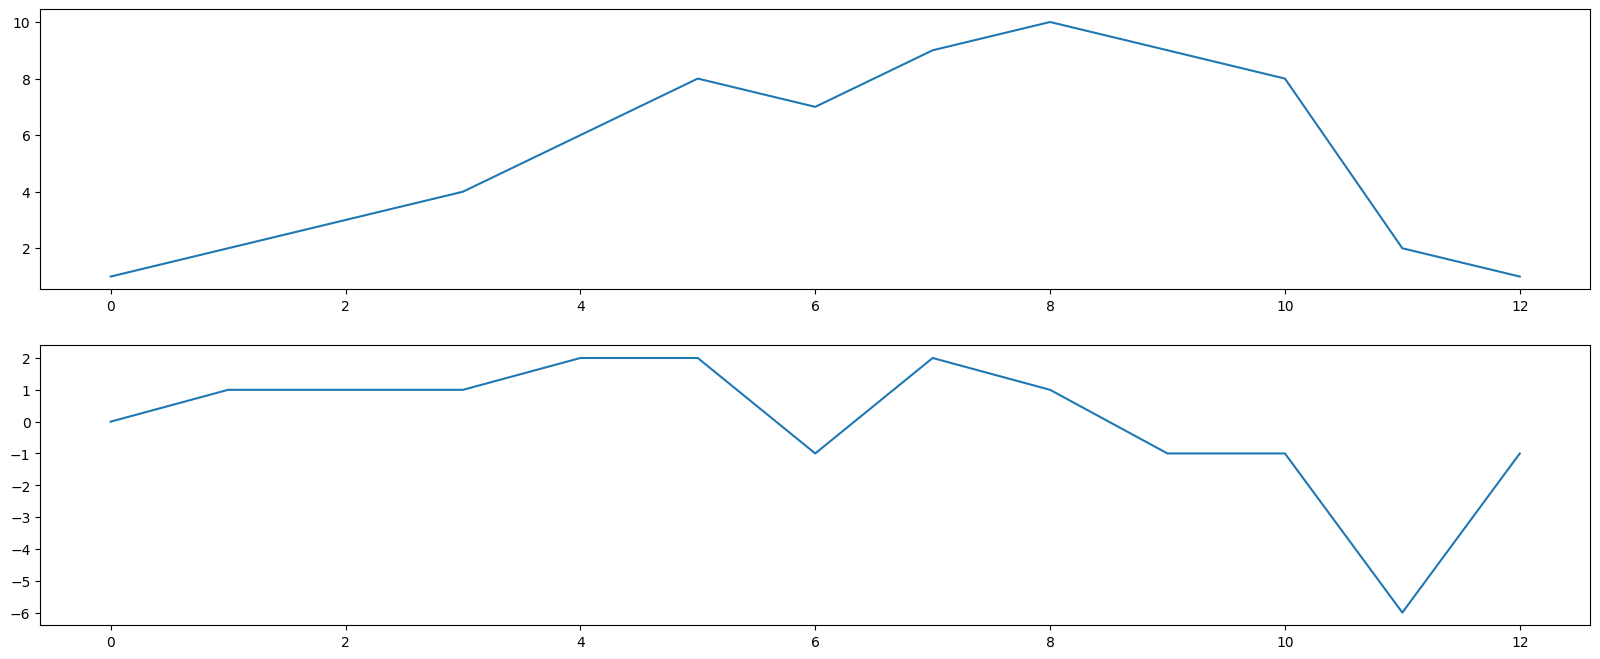

In [18]:
lrx = LRX_bit(28) # up to 63 # 64 - experimental

# states = lrx.state_destination

# signed_to_hex(states.item()),\
# signed_to_hex(lrx.R(states).item()),\
# signed_to_hex(lrx.L(states).item()),\
# signed_to_hex(lrx.X(states).item())

sr = lrx.bfs_growth(print_thres=1000, verbose=0) # 24

sr = {k:v for k,v in sr.items() if v>0}

df = pd.Series(sr).to_frame()
df[1] = df[0].diff().fillna(0)

fig, axes = plt.subplots(nrows=2, ncols=1)

df[0].plot(ax=axes[0], figsize=(20,8))
df[1].plot(ax=axes[1], figsize=(20,8))

print(str(sr))

{0: 1, 1: 2, 2: 3, 3: 4, 4: 6, 5: 8, 6: 7, 7: 9, 8: 10, 9: 9, 10: 8, 11: 2, 12: 1}


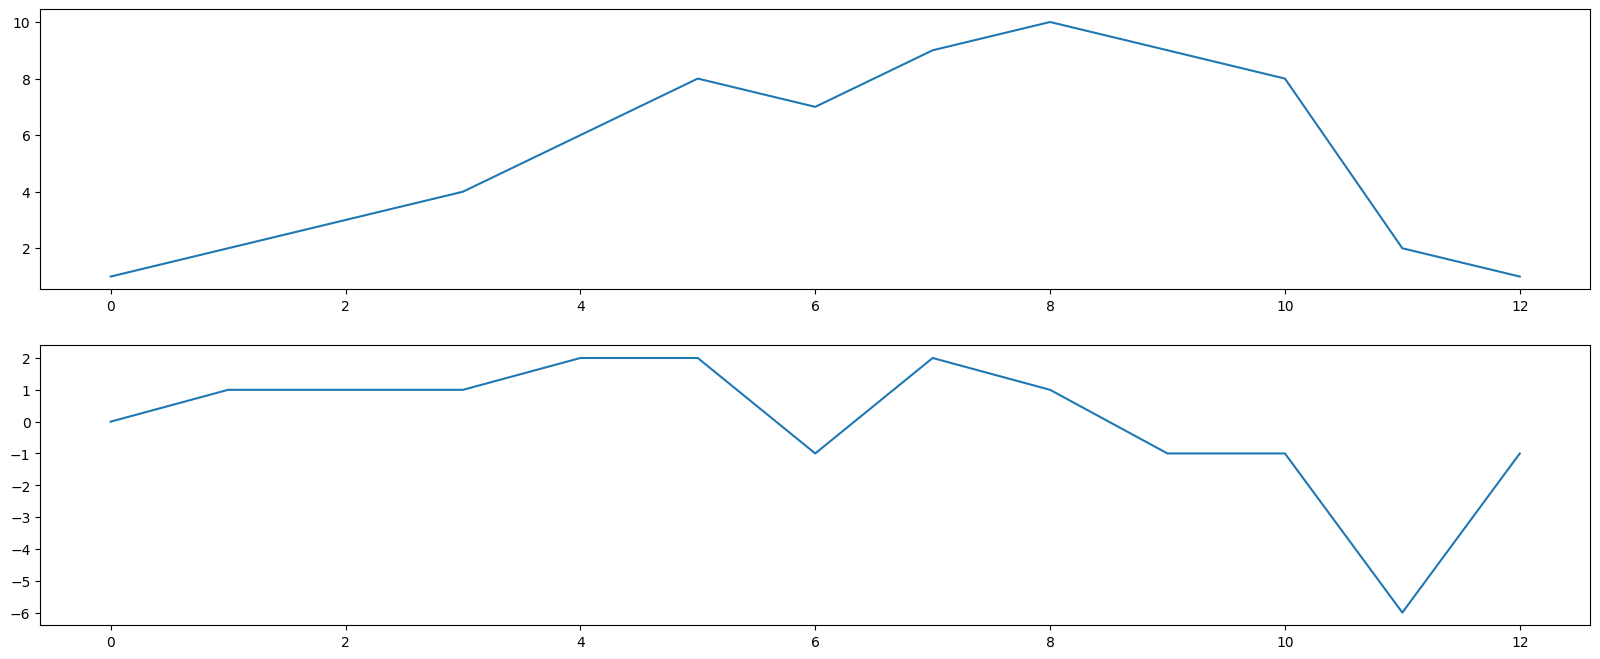

In [18]:
lrx = LRX_bit(30) # up to 63 # 64 - experimental

# states = lrx.state_destination

# signed_to_hex(states.item()),\
# signed_to_hex(lrx.R(states).item()),\
# signed_to_hex(lrx.L(states).item()),\
# signed_to_hex(lrx.X(states).item())

sr = lrx.bfs_growth(print_thres=1000, verbose=0) # 24

sr = {k:v for k,v in sr.items() if v>0}

df = pd.Series(sr).to_frame()
df[1] = df[0].diff().fillna(0)

fig, axes = plt.subplots(nrows=2, ncols=1)

df[0].plot(ax=axes[0], figsize=(20,8))
df[1].plot(ax=axes[1], figsize=(20,8))

print(str(sr))

{0: 1, 1: 2, 2: 3, 3: 4, 4: 6, 5: 8, 6: 7, 7: 9, 8: 10, 9: 9, 10: 8, 11: 2, 12: 1}


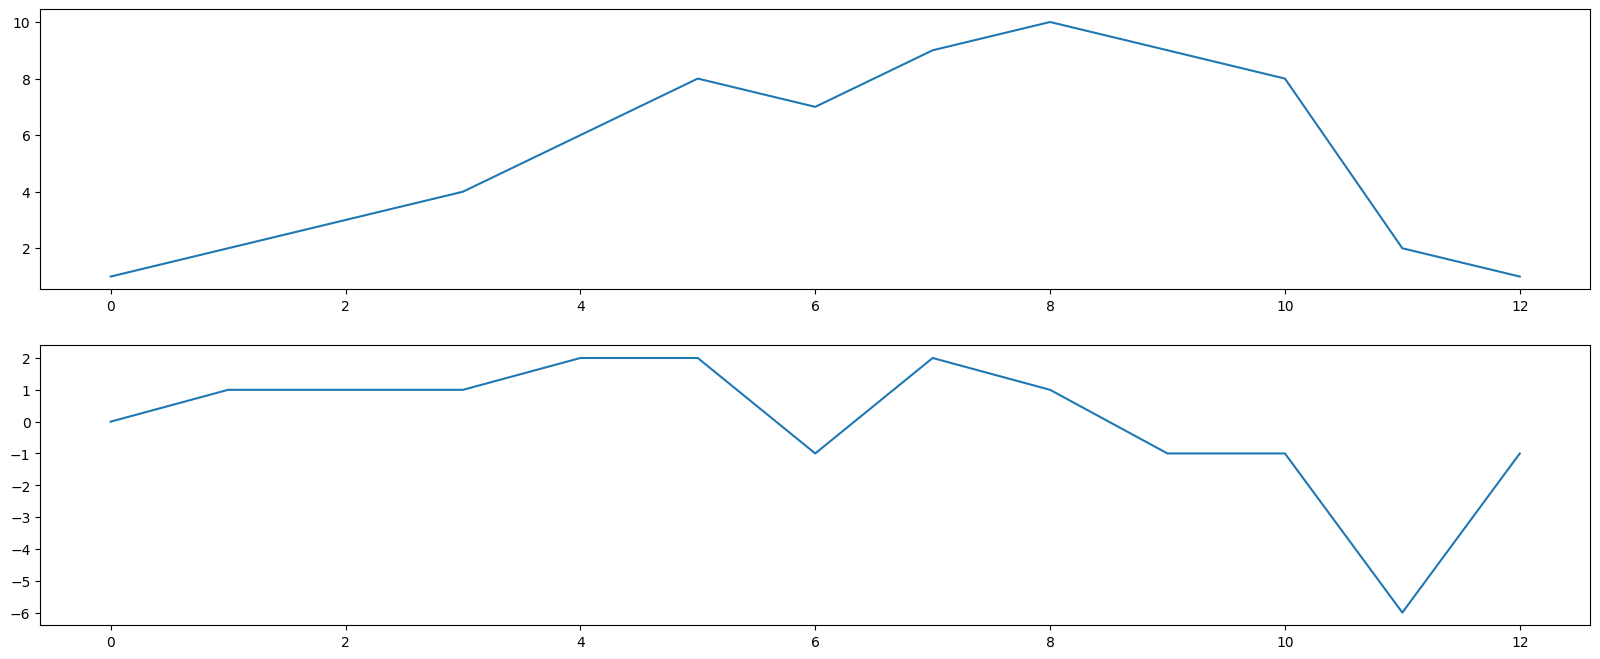

In [18]:
lrx = LRX_bit(32) # up to 63 # 64 - experimental

# states = lrx.state_destination

# signed_to_hex(states.item()),\
# signed_to_hex(lrx.R(states).item()),\
# signed_to_hex(lrx.L(states).item()),\
# signed_to_hex(lrx.X(states).item())

sr = lrx.bfs_growth(print_thres=1000, verbose=0) # 24

sr = {k:v for k,v in sr.items() if v>0}

df = pd.Series(sr).to_frame()
df[1] = df[0].diff().fillna(0)

fig, axes = plt.subplots(nrows=2, ncols=1)

df[0].plot(ax=axes[0], figsize=(20,8))
df[1].plot(ax=axes[1], figsize=(20,8))

print(str(sr))

{0: 1, 1: 2, 2: 3, 3: 4, 4: 6, 5: 8, 6: 7, 7: 9, 8: 10, 9: 9, 10: 8, 11: 2, 12: 1}


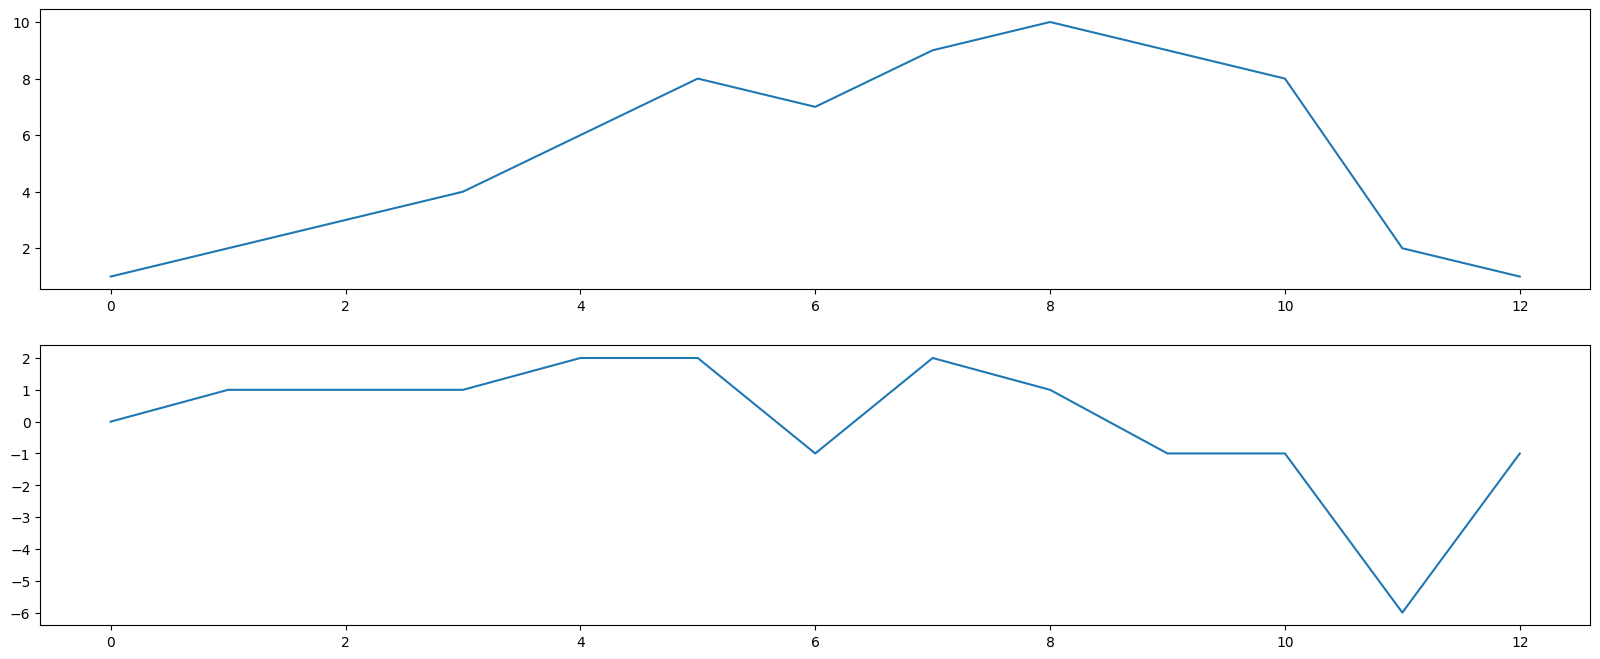

In [18]:
lrx = LRX_bit(34) # up to 63 # 64 - experimental

# states = lrx.state_destination

# signed_to_hex(states.item()),\
# signed_to_hex(lrx.R(states).item()),\
# signed_to_hex(lrx.L(states).item()),\
# signed_to_hex(lrx.X(states).item())

sr = lrx.bfs_growth(print_thres=1000, verbose=0) # 24

sr = {k:v for k,v in sr.items() if v>0}

df = pd.Series(sr).to_frame()
df[1] = df[0].diff().fillna(0)

fig, axes = plt.subplots(nrows=2, ncols=1)

df[0].plot(ax=axes[0], figsize=(20,8))
df[1].plot(ax=axes[1], figsize=(20,8))

print(str(sr))

{0: 1, 1: 2, 2: 3, 3: 4, 4: 6, 5: 8, 6: 7, 7: 9, 8: 10, 9: 9, 10: 8, 11: 2, 12: 1}


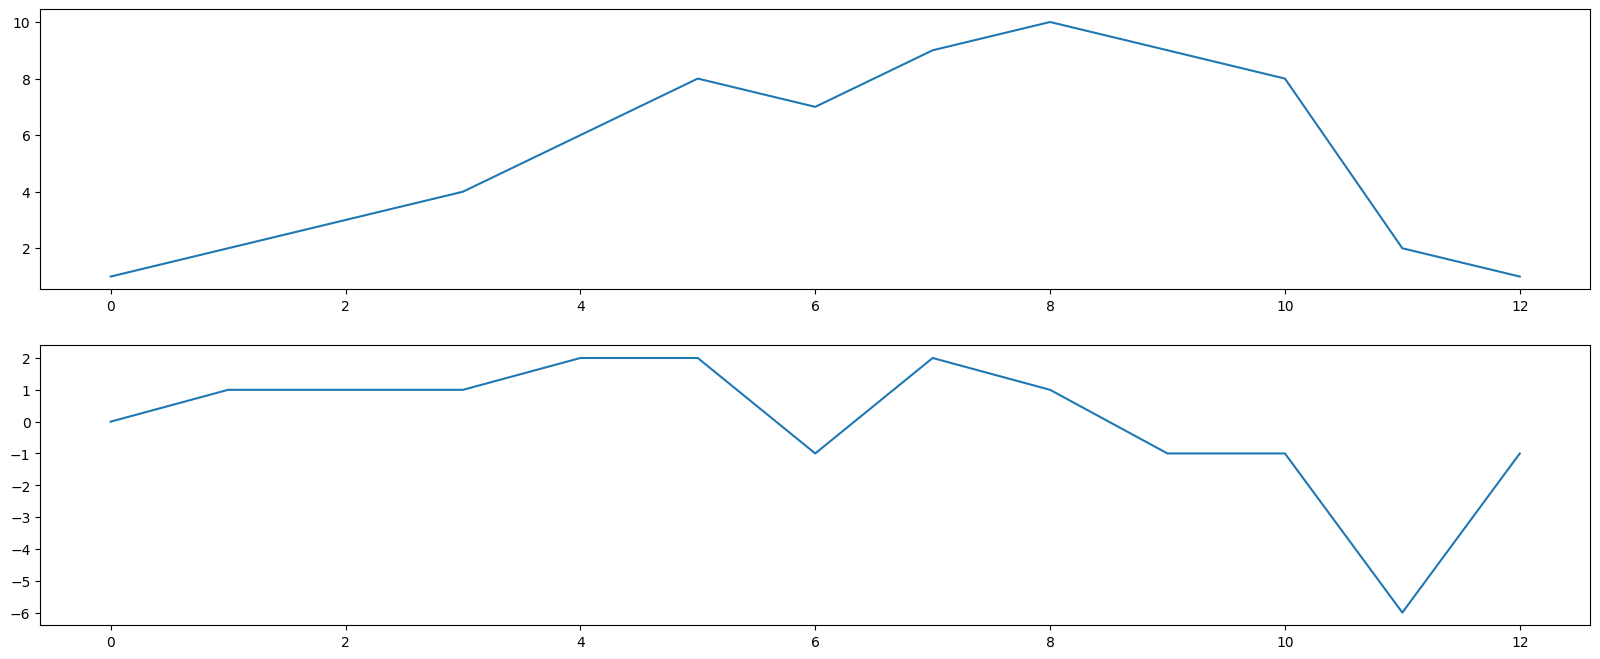

In [18]:
lrx = LRX_bit(36) # up to 63 # 64 - experimental

# states = lrx.state_destination

# signed_to_hex(states.item()),\
# signed_to_hex(lrx.R(states).item()),\
# signed_to_hex(lrx.L(states).item()),\
# signed_to_hex(lrx.X(states).item())

sr = lrx.bfs_growth(print_thres=1000, verbose=0) # 24

sr = {k:v for k,v in sr.items() if v>0}

df = pd.Series(sr).to_frame()
df[1] = df[0].diff().fillna(0)

fig, axes = plt.subplots(nrows=2, ncols=1)

df[0].plot(ax=axes[0], figsize=(20,8))
df[1].plot(ax=axes[1], figsize=(20,8))

print(str(sr))

In [22]:
lrx = LRX_bit(38) # up to 63 # 64 - experimental

# states = lrx.state_destination

# signed_to_hex(states.item()),\
# signed_to_hex(lrx.R(states).item()),\
# signed_to_hex(lrx.L(states).item()),\
# signed_to_hex(lrx.X(states).item())

sr = lrx.bfs_growth(print_thres=1000, verbose=0) # 24

sr = {k:v for k,v in sr.items() if v>0}

df = pd.Series(sr).to_frame()
df[1] = df[0].diff().fillna(0)

fig, axes = plt.subplots(nrows=2, ncols=1)

df[0].plot(ax=axes[0], figsize=(20,8))
df[1].plot(ax=axes[1], figsize=(20,8))

print(str(sr))

OutOfMemoryError: CUDA out of memory. Tried to allocate 1.27 GiB. GPU 0 has a total capacity of 15.89 GiB of which 827.12 MiB is free. Process 2364 has 15.08 GiB memory in use. Of the allocated memory 10.77 GiB is allocated by PyTorch, and 4.03 GiB is reserved by PyTorch but unallocated. If reserved but unallocated memory is large try setting PYTORCH_CUDA_ALLOC_CONF=expandable_segments:True to avoid fragmentation.  See documentation for Memory Management  (https://pytorch.org/docs/stable/notes/cuda.html#environment-variables)

In [22]:
lrx = LRX_bit(40) # up to 63 # 64 - experimental

# states = lrx.state_destination

# signed_to_hex(states.item()),\
# signed_to_hex(lrx.R(states).item()),\
# signed_to_hex(lrx.L(states).item()),\
# signed_to_hex(lrx.X(states).item())

sr = lrx.bfs_growth(print_thres=1000, verbose=0) # 24

sr = {k:v for k,v in sr.items() if v>0}

df = pd.Series(sr).to_frame()
df[1] = df[0].diff().fillna(0)

fig, axes = plt.subplots(nrows=2, ncols=1)

df[0].plot(ax=axes[0], figsize=(20,8))
df[1].plot(ax=axes[1], figsize=(20,8))

print(str(sr))

OutOfMemoryError: CUDA out of memory. Tried to allocate 1.27 GiB. GPU 0 has a total capacity of 15.89 GiB of which 827.12 MiB is free. Process 2364 has 15.08 GiB memory in use. Of the allocated memory 10.77 GiB is allocated by PyTorch, and 4.03 GiB is reserved by PyTorch but unallocated. If reserved but unallocated memory is large try setting PYTORCH_CUDA_ALLOC_CONF=expandable_segments:True to avoid fragmentation.  See documentation for Memory Management  (https://pytorch.org/docs/stable/notes/cuda.html#environment-variables)

In [22]:
lrx = LRX_bit(42) # up to 63 # 64 - experimental

# states = lrx.state_destination

# signed_to_hex(states.item()),\
# signed_to_hex(lrx.R(states).item()),\
# signed_to_hex(lrx.L(states).item()),\
# signed_to_hex(lrx.X(states).item())

sr = lrx.bfs_growth(print_thres=1000, verbose=0) # 24

sr = {k:v for k,v in sr.items() if v>0}

df = pd.Series(sr).to_frame()
df[1] = df[0].diff().fillna(0)

fig, axes = plt.subplots(nrows=2, ncols=1)

df[0].plot(ax=axes[0], figsize=(20,8))
df[1].plot(ax=axes[1], figsize=(20,8))

print(str(sr))

OutOfMemoryError: CUDA out of memory. Tried to allocate 1.27 GiB. GPU 0 has a total capacity of 15.89 GiB of which 827.12 MiB is free. Process 2364 has 15.08 GiB memory in use. Of the allocated memory 10.77 GiB is allocated by PyTorch, and 4.03 GiB is reserved by PyTorch but unallocated. If reserved but unallocated memory is large try setting PYTORCH_CUDA_ALLOC_CONF=expandable_segments:True to avoid fragmentation.  See documentation for Memory Management  (https://pytorch.org/docs/stable/notes/cuda.html#environment-variables)